**Project - DQN**

**Christopher Pillay - 1362077**

**Siddeeq Laher - 1727869**

**Zaeem Asvat - 1748323**

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y build-essential autoconf libtool pkg-config \
       python3-dev python3-pip python3-numpy git libncurses5-dev \
       libzmq3-dev flex bison

In [2]:
%%capture
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install 

In [3]:
!pip3 install cmake==3.15.3
!pip3 install nle

     |████████████████████████████████| 16.5MB 217kB/s 
  Found existing installation: cmake 3.12.0
    Uninstalling cmake-3.12.0:
      Successfully uninstalled cmake-3.12.0
     |████████████████████████████████| 6.7MB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/00/84/fc9dc13ee536ba5e6b8fd10ce368fea5b738fe394c3b296cde7c9b144a92/pybind11-2.6.1-py2.py3-none-any.whl
  Created wheel for nle: filename=nle-0.6.0-cp36-cp36m-linux_x86_64.whl size=2847876 sha256=926da068f94d4f84b9b25c5c096527dcf7b7a96ddffe45ac87c1fde3b27c8528
  Stored in directory: /root/.cache/pip/wheels/b5/4d/7c/e4c74b776f945ec1bc9bf01dc94bc226e452cf7dd2aba347a2
Successfully built nle


In [4]:
import random
import numpy as np
import gym
from gym import spaces
from gym import wrappers
import nle
import matplotlib.pyplot as plt
from collections import deque
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


**Replay Buffer**

In [5]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)


**Agent**

In [6]:
device = "cuda"

class DQNAgent:
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """

        # TODO: Initialise agent's networks, optimiser and replay buffer
        #Networks
        self.policy_network = DQN(observation_space, action_space).to(device)
        self.target_network = DQN(observation_space, action_space).to(device)
        self.batch_size = batch_size
        self.use_double_dqn = use_double_dqn
        self.gamma = gamma
        self.update_target_network()
        self.target_network.eval()
        
        #Optimiser
        self.optimiser = optim.Adam(self.policy_network.parameters(), lr=lr)

        #Replay Buffer
        self.experience_replay = replay_buffer

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        #Sample random minibatch (batch_size) of transitions from replay memory
        states, actions, rewards, next_states, dones = self.experience_replay.sample(self.batch_size)

        states = np.array(states) 
        next_states = np.array(next_states)

        #Convert transitions to tensors from numpy arrays
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        #Get current value
        curr_values = self.policy_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        #Get Target Value
        with torch.no_grad():
            if self.use_double_dqn:
                _, next_action = self.policy_network(next_states).max(1)
                next_values = self.target_network(next_states).gather(1, next_action.unsqueeze(1)).squeeze()
            else:
                next_values, _ = self.target_network(next_states).max(1)                
            target_values = rewards + (1 - dones) * self.gamma * next_values

        #Gradient descent
        loss = F.smooth_l1_loss(curr_values, target_values)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            _, action = self.policy_network(state).max(1)
            return action.item()

**Model**

In [7]:
class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network. The architecture is the same as that described in the
    Nature DQN paper.
    """

    def __init__(self, observation_space: tuple, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param observation_space: the state space of the environment
        :param action_space: the action space of the environment
        """
        super().__init__()

        self.convolutional_layer_1 = nn.Conv2d(observation_space[0], out_channels=32, kernel_size=4, stride=3)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=32)
        self.convolutional_layer_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=64)
        self.convolutional_layer_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=64)
        
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(21,4,3),3,2),2,1)
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(79,4,3),3,2),2,1) 
        conv_out_size = convw*convh*64

        self.linear_1 = nn.Linear(conv_out_size + 25, 512)
        self.linear_2 = nn.Linear(512, action_space.n)

    def forward(self, x):

        # configure glyphs input
        glyphs = x[:, :, 0:21, 0:79]
        
        # process glyphs data
        glyphs = F.relu(self.batch_norm_1(self.convolutional_layer_1(glyphs)))
        glyphs = F.relu(self.batch_norm_2(self.convolutional_layer_2(glyphs)))
        glyphs = F.relu(self.batch_norm_3(self.convolutional_layer_3(glyphs)))
        glyphs = glyphs.view(glyphs.size(0),-1)

        # configure stats input
        stats = x[:, :, 22, :25]
        stats = torch.reshape(stats, (-1, 25))

        # concat stats with conv glyphs
        glyphs_stats = torch.cat((glyphs, stats), 1)
        glyphs_stats = F.relu(self.linear_1(glyphs_stats)) 
        
        output = self.linear_2(glyphs_stats)

        return output

    def conv2d_size_out(self, size, kernel_size, stride):
        return ((size - kernel_size) // stride)  + 1

**train_nethack**

In [8]:
def preprocess_state(state):
    temp = np.zeros((1,23,79))

    temp[0, 0:21, 0:79] = state['glyphs']
    temp[0, 22, :25] = state['blstats'] 

    return temp

********************************************************
steps: 18023
episodes: 10
mean 100 episode reward: 44.3
% time spent exploring: 98
********************************************************
********************************************************
steps: 34074
episodes: 20
mean 100 episode reward: 31.9
% time spent exploring: 97
********************************************************
********************************************************
steps: 55728
episodes: 30
mean 100 episode reward: 34.2
% time spent exploring: 96
********************************************************
********************************************************
steps: 82842
episodes: 40
mean 100 episode reward: 29.1
% time spent exploring: 95
********************************************************
********************************************************
steps: 97405
episodes: 50
mean 100 episode reward: 27.4
% time spent exploring: 94
********************************************************
***************

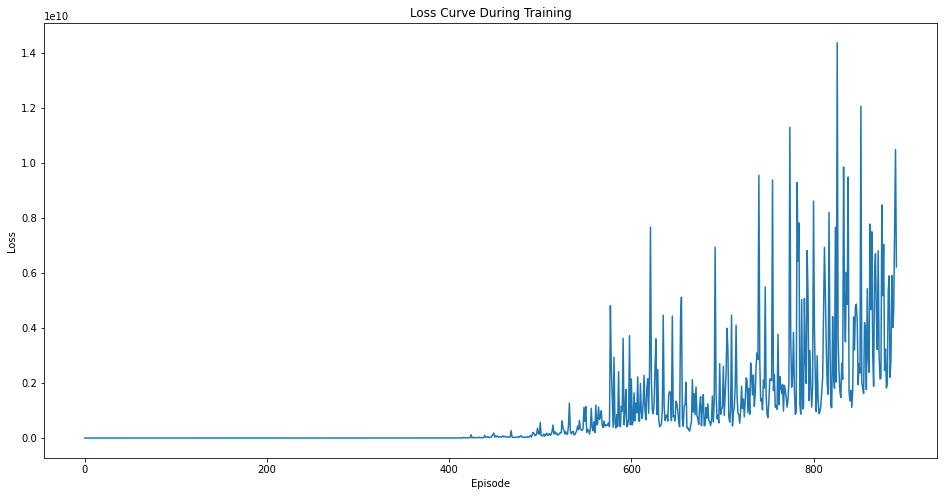

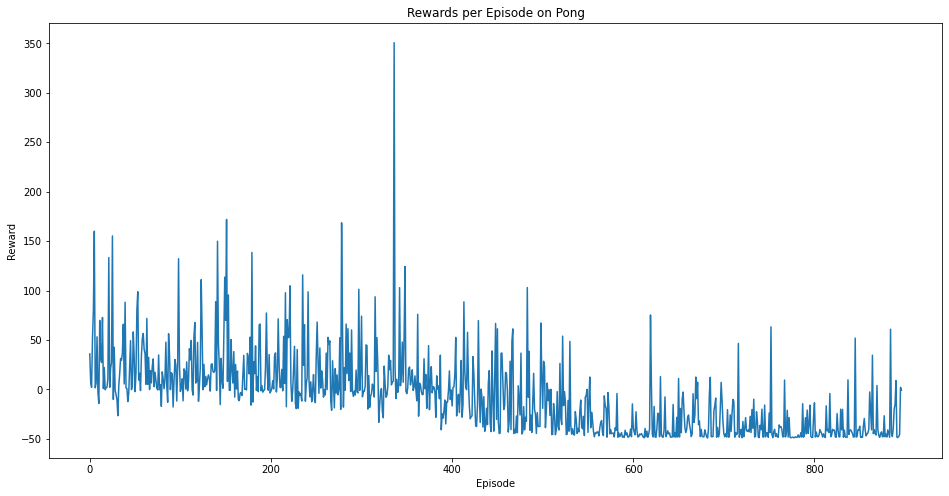

In [ ]:
if __name__ == "__main__":

    hyper_params = {
        "seed": 42,  # which seed to use
        "env": "NetHackScore-v0",  # name of the game
        "replay-buffer-size": int(1e6),  # replay buffer size
        "learning-rate": 0.001,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(3e6),  # total number of steps to run the environment for
        "batch-size": 32,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 5,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.1,  # e-greedy end threshold
        "eps-fraction": 0.5,  # fraction of num-steps
        "print-freq": 10,
    }

    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])

    env = gym.make(hyper_params["env"])
    env.seed(hyper_params["seed"])

    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    # TODO Create dqn agent
    agent = DQNAgent(
        (1,23,79),
        env.action_space,
        replay_buffer,
        use_double_dqn=hyper_params["use-double-dqn"],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['discount-factor']
    )

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]
    model_loss = []
    episode_loss = 0
    prev_t = 0

    state = env.reset()
    state = preprocess_state(state)
    for t in range(hyper_params["num-steps"]):
        fraction = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fraction * (hyper_params["eps-end"] - hyper_params["eps-start"])
        sample = random.random()

        # TODO
        # select random action if sample is less equal than eps_threshold
        if sample <= eps_threshold:
	          action = env.action_space.sample()
        else:
            action = agent.act(state)

        # take step in env
        next_state, reward, done, info = env.step(action)
        next_state = preprocess_state(next_state)

        # add state, action, reward, next_state, float(done) to replay memory - cast done to float
        agent.experience_replay.add(state, action, reward, next_state, float(done))

        # add reward to episode_reward
        episode_rewards[-1] += reward

        #Update State
        state = next_state

        if done:
            state = env.reset()
            state = preprocess_state(state)
            episode_rewards.append(0.0)
            if (t > hyper_params["learning-starts"]):
                model_loss.append(episode_loss / (t - prev_t))
                prev_t = t
                episode_loss = 0

        if (t > hyper_params["learning-starts"] and t % hyper_params["learning-freq"] == 0):
            episode_loss += agent.optimise_td_loss()

        if (t > hyper_params["learning-starts"] and t % hyper_params["target-update-freq"] == 0):
            agent.update_target_network()

        num_episodes = len(episode_rewards)

        if (done and hyper_params["print-freq"] is not None and len(episode_rewards) % hyper_params["print-freq"] == 0):
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")
        #Save model every 100000 steps
        if t%100000 == 0:
          torch.save(agent.policy_network.state_dict(), '/content/drive/My Drive/DQN_nle.pt')

    #Save model when training is completed
    torch.save(agent.policy_network.state_dict(), '/content/drive/My Drive/DQN_nlef.pt')

    #Plot model loss
    plt.figure(figsize=(16,8))
    plt.plot(model_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss Curve During Training')
    plt.show()

    #Plot rewards per episode
    plt.figure(figsize=(16,8))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.show()

In [13]:
class AbstractAgent:
    """
    AbstractAgent

    """

    def __init__(self, **kwargs):
        raise NotImplementedError()

    def act(self, observation):
        raise NotImplementedError()


class MyAgent(AbstractAgent):
    def __init__(self, observation_space, action_space, **kwargs):
        self.observation_space = observation_space
        self.action_space = action_space
        self.seeds = kwargs.get('seeds', None)
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = DQNAgent(
        (1,23,79),
        env.action_space,
        replay_buffer,
        use_double_dqn=hyper_params["use-double-dqn"],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['discount-factor'])
        self.model.policy_network.load_state_dict(torch.load( '/content/drive/My Drive/DQN_nlef.pt', map_location=torch.device(device)))

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            _, action = self.model.policy_network(state).max(1)
            return action.item()


import numpy as np
import gym
import nle
import random
import csv
import os

def run_episode(env,seed,episode_num):
    # create instance of MyAgent
    # from MyAgent import MyAgent
    agent = MyAgent(env.observation_space, env.action_space)

    done = False
    episode_return = 0.0
    state = env.reset()
    stats_list = [np.zeros(25),np.zeros(25)]
    steps = 0
    max_depth = 0
    while not done:
        # pass state to agent and let agent decide action
        new_state = preprocess_state(state)
        action = agent.act(new_state)
        new_state, reward, done, _ = env.step(action)
        steps += 1
        episode_return += reward
        # Update list of episode stats
        stats_list = update_stat_list(stats_list,state)
        if stats_list[0][12] > max_depth:
            max_depth = stats_list[0][12]
        # Check if done
        if done:
            row = get_stats(stats_list[0],steps,max_depth,seed,episode_num)

        state = new_state
    return episode_return,row

def get_stats(stats,steps,max_depth,seed,episode_num):
    return [1, # end_status, 1 = episode ended correctly. This is assumed here
        stats[9], # This is the ingame score, which may differ from the total returns
        stats[20], # time
        steps,stats[10], # steps in this episode
        stats[19], # health points
        stats[18], # experience
        stats[13], # experience level
        stats[21], # gold
        "UNK", # name of killer. env doesn't store this, so just left as unknown
        max_depth, # The furthest depth the agent went this episode
        episode_num, # The number of the episode
        seed, # The env seed
        "episode_"+str(episode_num)+".ttyrec"] # the name of the corresponding ttyrec file in stats.zip

def update_stat_list(stats_list,state):
    # Hacky stuff to get the right stats vector
    stats_list[0] = stats_list[1]
    stats_list[1] = list(state['blstats'])
    return stats_list

hyper_params = {
        "seed": 42,  # which seed to use
        "env": "NetHackScore-v0",  # name of the game
        "replay-buffer-size": int(1e6),  # replay buffer size
        "learning-rate": 0.001,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(3e6),  # total number of steps to run the environment for
        "batch-size": 32,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 5,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.1,  # e-greedy end threshold
        "eps-fraction": 0.5,  # fraction of num-steps
        "print-freq": 10,
    }
replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])
# if __name__ == '__main__':
# Directory
dir = os.getcwd()

# Seed
seeds = [1,2,3,4,5]

# Initialise environment
env = gym.make("NetHackScore-v0")

# Generate CSV
stats_list = [['end_status','score','time','steps','hp','exp','exp_lev',
'gold','hunger','killer_name','deepest_lev','episode','seeds','ttyrec']]

# Run one episode
rewards = []
episode_num = 1
for seed in seeds:
    env.seed(seed)
    seed_rewards = []
    reward,row = run_episode(env,seed,episode_num)
    stats_list.append(row)
    episode_num += 1
    rewards.append(reward)
# Close environment and print average reward
env.close()
print("Average Reward: %f" %(np.mean(rewards)))

# Write to csv
# NOTE: Unfortunately, you will need to either rename each ttyrec file to
#   match stats.csv or change the entry in stats.csv to point to the
#   appropriate ttyrec file
os.chdir(dir)
file = open('stats.csv','w+',newline='')
with file:
    writer = csv.writer(file)
    writer.writerows(stats_list)
file.close()


Average Reward: -49.996000
